In [1]:
import os

In [2]:
os.environ['KAGGLE_USERNAME'] = 'mason0908'
os.environ['KAGGLE_KEY'] = 'd6bcff4b46ed3f938f86b1a4d69f1694'

In [3]:
!kaggle datasets download -d deepcontractor/car-price-prediction-challenge

  0% 0.00/429k [00:00<?, ?B/s]
100% 429k/429k [00:00<00:00, 106MB/s]


In [4]:
!unzip *.*

Archive:  car-price-prediction-challenge.zip
  inflating: car_price_prediction.csv  


다음은 데이터에 대한 설명입니다:
1. ID - 데이터 셋에 대한 기본 키
2. Price - 자동차의 가격을 나타내는 값으로 우리가 예측하고자 하는 목표값
3. Levy -
4. Manufacturer - 자동차 제조 회사
5. Model - 자동차 모델
6. Prod.year - 생산 년도
7. Category - 자동차의 형태 (SUV, 세단, 해치백 등)
8. Leather interior - 내부가 가죽으로 되어있는가를 의미하는 변수
9. Fuel type - 자동차 연료 종류 (휘발유, 디젤 등)
10. Engine volume - 엔진 용량
11. Mileage - 주행 거리
12. Cylinders - 자동차 엔진의 종류 (몇 기통인지를 나타내는 변수)
13. Gear box type - 변속기 (자동 변속기인지 수동 변속기인지를 나타내는 변수)
14. Drive wheels - 구륜동 (전륜구동인지 사륜구동인지를 나타내는 변수)
15.Doors - 문 개수
16. Whell - 운전석 위치
17. Color - 자동차의 색
18. Airbags - 에어백 개수


In [5]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.1 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [7]:
#데이터셋 로드
df = pd.read_csv("/content/car_price_prediction.csv")

In [8]:
#데이터프레임 상위 5개 데이터 확인
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [9]:
#데이터프레임 차원 확인
df.shape

(19237, 18)

In [10]:
#데이터프레임 타입정보
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [11]:
#데이터프레임 통계학적 정보
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,19237.0,4.557654e+07,936591.422799,20746880.0,45698374.0,45772308.0,45802036.0,45816654.0
Price,19237.0,1.855593e+04,190581.269684,1.0,5331.0,13172.0,22075.0,26307500.0
Prod. year,19237.0,2.010913e+03,5.668673,1939.0,2009.0,2012.0,2015.0,2020.0
Cylinders,19237.0,4.582991e+00,1.199933,1.0,4.0,4.0,4.0,16.0
Airbags,19237.0,6.582627e+00,4.320168,0.0,4.0,6.0,12.0,16.0


In [12]:
#데이터프레임의 NaN값 확인
df.isna().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [13]:
#데이터프레임의 중복값 확인
df['ID'].duplicated().sum()

313

In [14]:
#Levy 열 확인
df['Levy'].value_counts()

-       5819
765      486
891      461
639      410
640      405
        ... 
3156       1
2908       1
1279       1
1719       1
1901       1
Name: Levy, Length: 559, dtype: int64

In [15]:
#Mileage 열 확인
df['Mileage'].value_counts()

0 km         721
200000 km    183
150000 km    161
160000 km    120
100000 km    119
            ... 
63083 km       1
28750 km       1
25077 km       1
77452 km       1
186923 km      1
Name: Mileage, Length: 7687, dtype: int64

Mileage 열은 수치값과 문자열이 섞여있다.

In [16]:
#Engine volumn 열 확인
df['Engine volume'].value_counts()

2            3916
2.5          2277
1.8          1760
1.6          1462
1.5          1321
             ... 
6.8             1
6.7             1
3.1             1
0.8 Turbo       1
1.1 Turbo       1
Name: Engine volume, Length: 107, dtype: int64

Engine volume 열은 수치값과 문자열이 섞여있다.

In [17]:
#Doors 열 확인
df['Doors'].value_counts()

04-May    18332
02-Mar      777
>5          128
Name: Doors, dtype: int64

Doors 열은 2-3, 4-5, >5로 변경되어야 한다.

In [18]:
#고유값인 'ID'열 제거
df.drop('ID', axis = 1, inplace=True)

In [19]:
#Levy 열 변화
df['Levy'] = pd.to_numeric(df['Levy'], errors='coerce')

Levy 열에서 수치값이 아닌 '-' 값을 모두 NaN 값으로 바꿔준다.

In [20]:
#Mileage 열 변환
df['Mileage'] = [float(value.split(' ')[0]) for value in df['Mileage']]

Mileage 열이 수치값만을 가지도록 'km' 문자열을 제거한다.`

In [21]:
#Engine volume 열 변환
df['Engine volume'] = [float(value.split(' ')[0]) for value in df['Engine volume']]

Engine volume 열이 수치값만을 가지도록 문자열을 제거한다.



In [22]:
#Doors 열 변환
df['Doors'].replace({'02-Mar':'2-3','04-May':'4-5'},inplace=True)

엑셀 변환 과정에서 잘못 저장된 것으로 예상되는 Doors 열의 값들을 변환해준다.

<Axes: xlabel='Levy', ylabel='Density'>

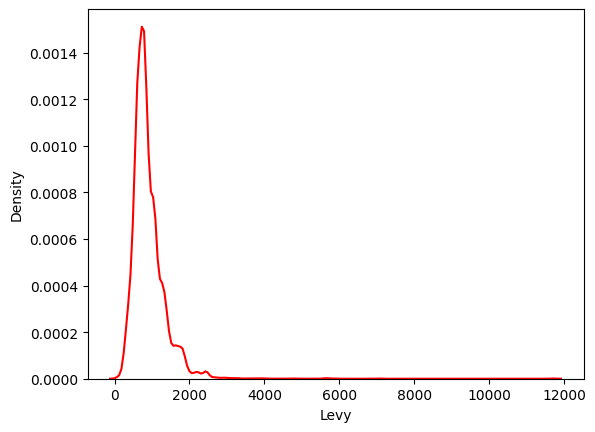

In [23]:
#Levy 특징 분포
sns.kdeplot(df['Levy'],color='r')

대부분의 값이 0 - 2000 사이에 존재한다.

Text(0.5, 1.0, '# of each Category')

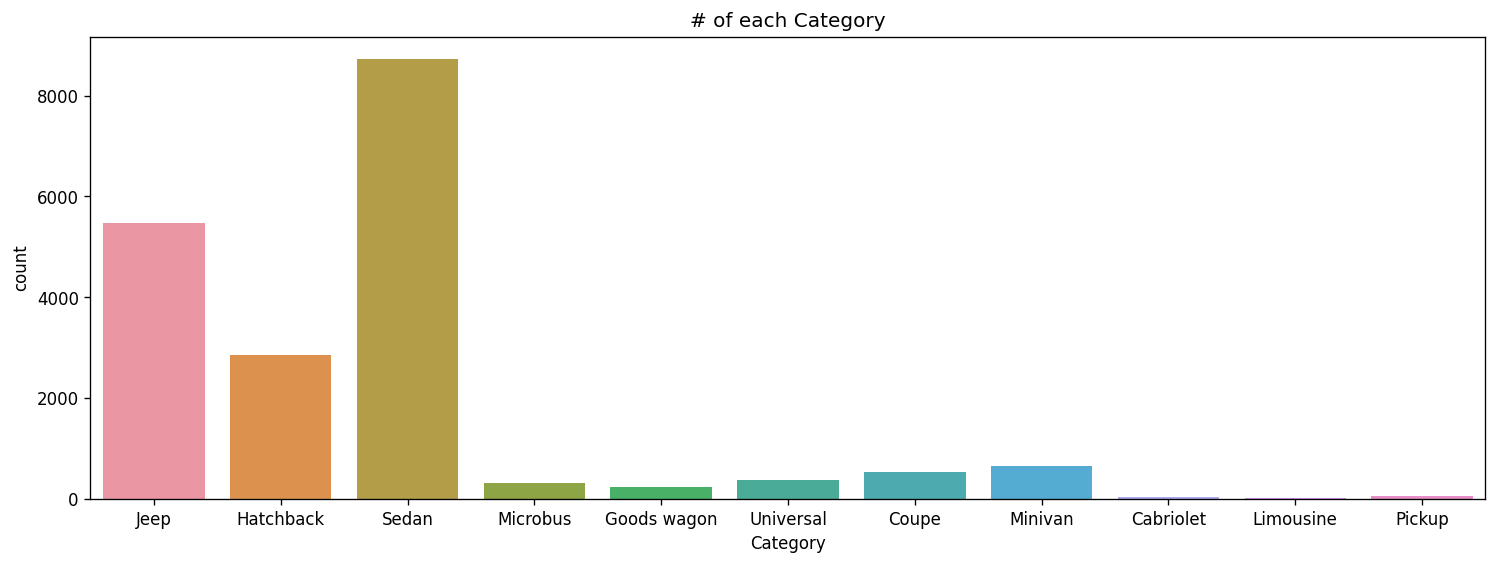

In [24]:
#Category 특징 분포
plt.subplots(figsize=(15,5),dpi=120)
sns.countplot(data = df,x='Category')
plt.title('# of each Category')

자동차의 대부분이 Sedan, Jeep, Hatchback인 것을 확인했다.

<ipython-input-25-6e928b7cb4d2>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Airbags'], color='b',shade = True)


<Axes: xlabel='Airbags', ylabel='Density'>

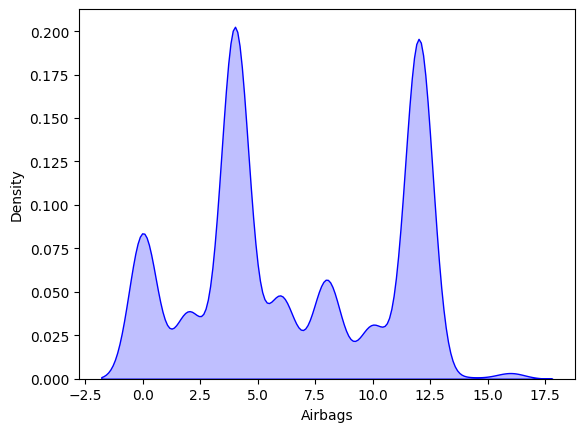

In [25]:
#Airbags 특징 분포
sns.kdeplot(df['Airbags'], color='b',shade = True)

대부분의 차량이 3 - 5개의 에어백이나 10 - 13개의 에어백을 가지고 있음을 확인했다.

In [26]:
df['Mileage']

0        186005.0
1        192000.0
2        200000.0
3        168966.0
4         91901.0
           ...   
19232    300000.0
19233    161600.0
19234    116365.0
19235     51258.0
19236    186923.0
Name: Mileage, Length: 19237, dtype: float64

<ipython-input-27-08abcafb75fa>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Mileage'], color = 'b', shade = True)


<Axes: xlabel='Mileage', ylabel='Density'>

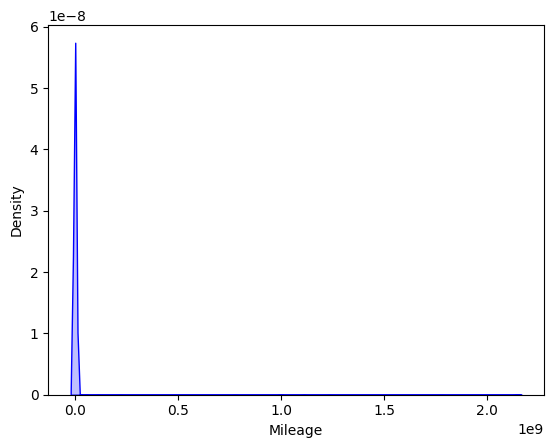

In [27]:
#Mileage 특징 분포
sns.kdeplot(df['Mileage'], color = 'b', shade = True)

Mileage 특징의 skewness가 매우 높은 것을 확인하였다.

<Axes: >

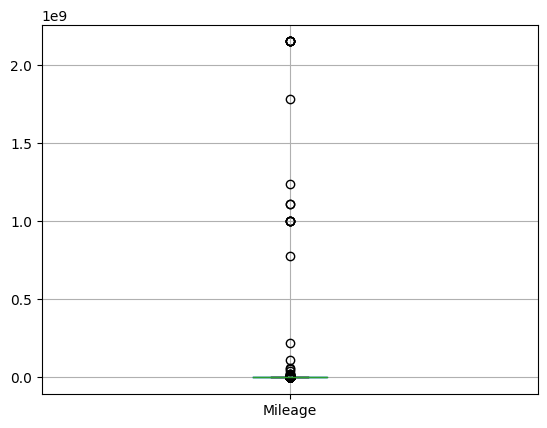

In [28]:
#Mileage 특징 분포
df.boxplot(column=['Mileage'])

Mileage 특징에 이상치들이 많은 것을 확인하였다. 추후에 작업을 통해 이상치들을 제거해줘야한다.

<Axes: xlabel='Prod. year', ylabel='Count'>

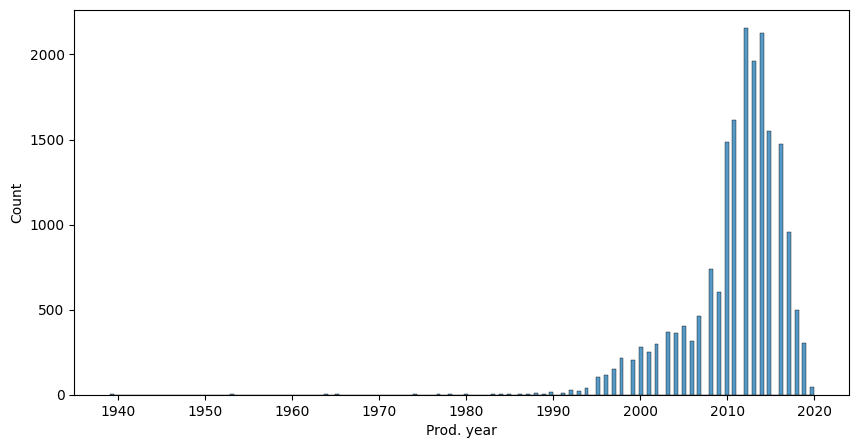

In [29]:
#prod.year 특징 분포
plt.figure(figsize=(10,5),dpi=100)
sns.histplot(df['Prod. year'])

2010 - 2020년 생산된 차량이 많은 것을 확인할 수 있다.

<ipython-input-30-5bbd6e97109a>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Engine volume'],shade = True)


<Axes: xlabel='Engine volume', ylabel='Density'>

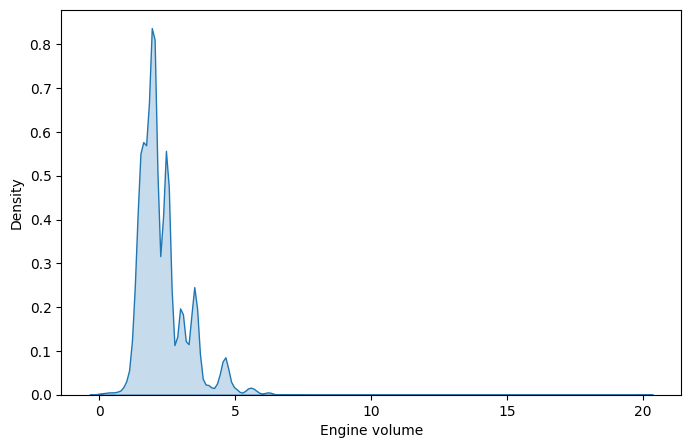

In [30]:
#Engine volume 특징 분포
plt.figure(figsize=(8,5), dpi=100)
sns.kdeplot(df['Engine volume'],shade = True)

Engine volume 특징은 대부분 1 - 5 사이 값을 가지고 있다.

Text(0.5, 1.0, '# of colors')

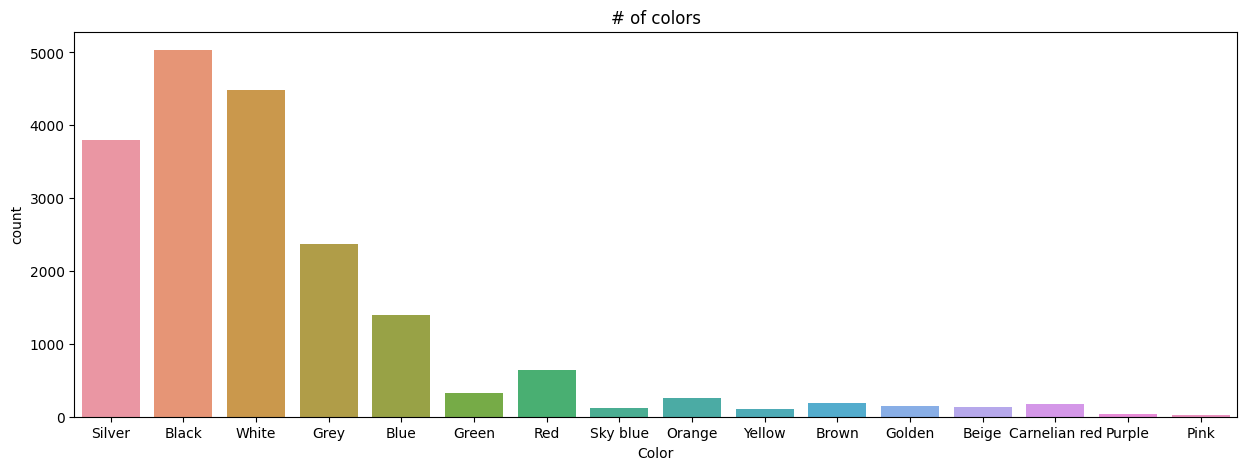

In [31]:
#color 특징 분포
plt.figure(figsize=(15,5), dpi=100)
sns.countplot(data=df, x='Color')
plt.title("# of colors")

<Axes: xlabel='Doors', ylabel='count'>

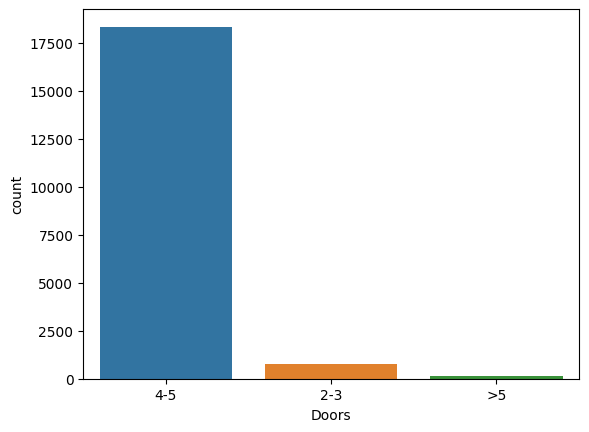

In [32]:
# Doors 특징 분포
sns.countplot(data=df, x='Doors')

대부분의 차량이 4 - 5개의 문을 가지고 있음을 확인하였다.

<Axes: xlabel='Price', ylabel='Levy'>

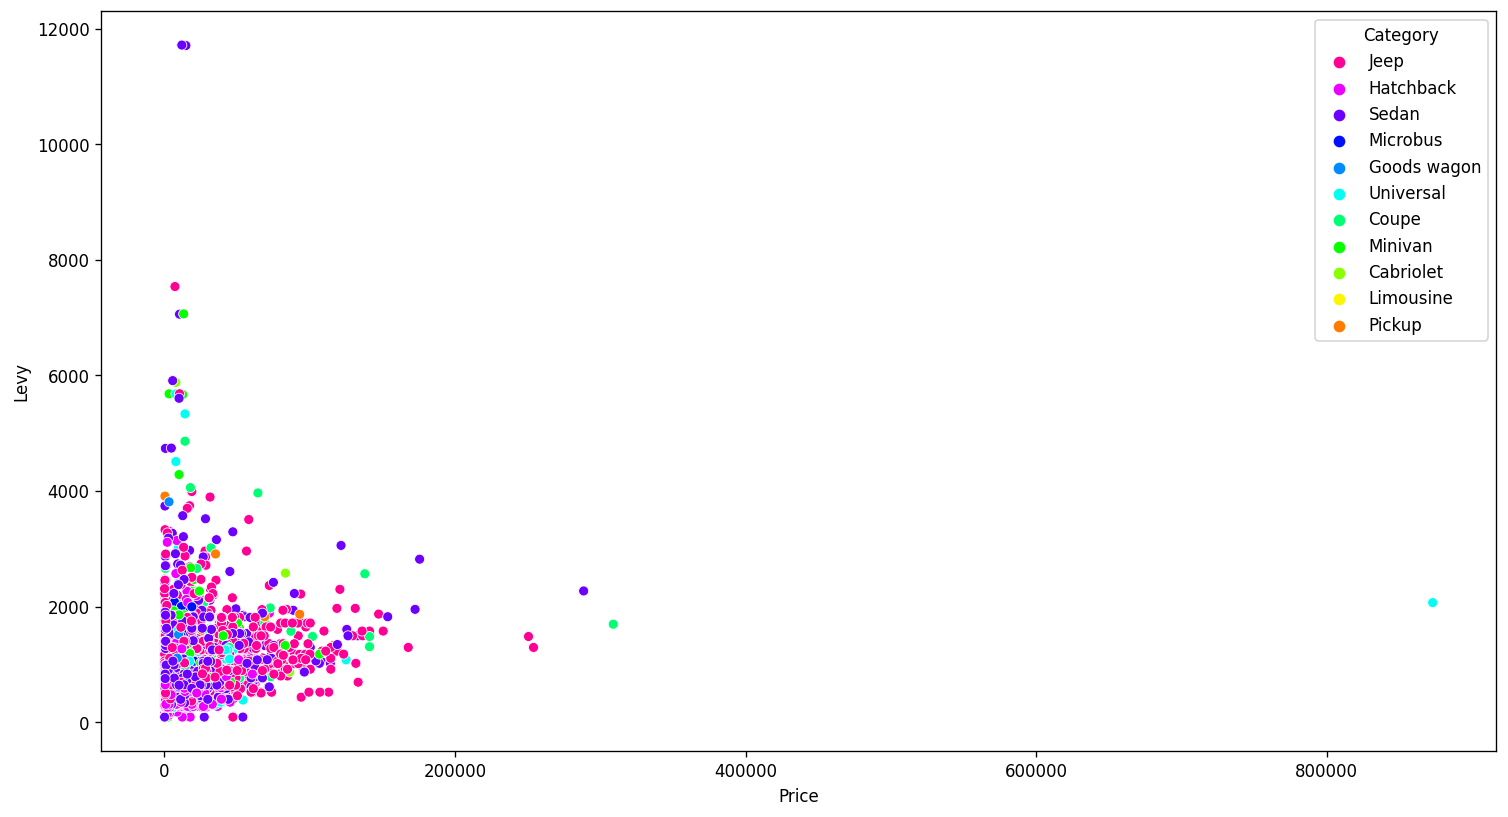

In [33]:
# Price, Levy 특징을 바탕으로 Category 별 산점도
plt.figure(figsize=(15, 8), dpi=120)
sns.scatterplot(data=df, x='Price', y='Levy', hue="Category", palette="hsv_r")

<Axes: >

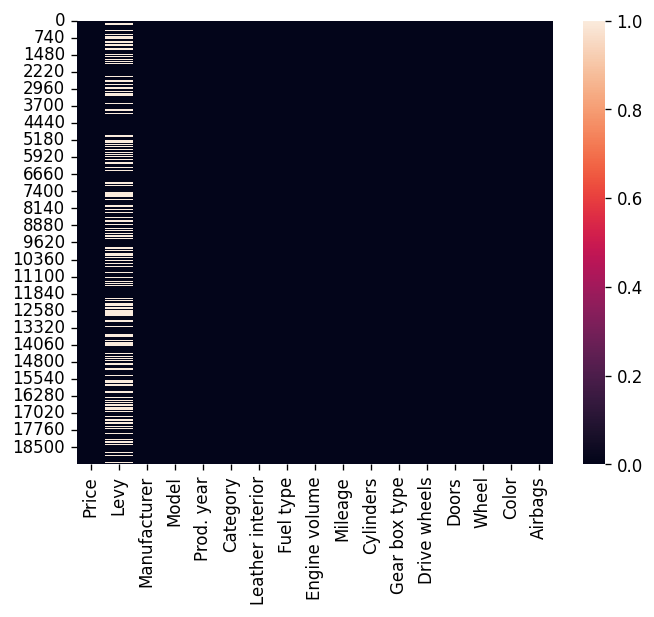

In [34]:
# NaN 값 확인
plt.figure(dpi=120)
sns.heatmap(df.isna())

In [35]:
# 중복값 제거
df.drop_duplicates(inplace=True)

In [36]:
# 차량 가격이 500 이하인 값들을 제거
df = df[df['Price'] > 500]

In [37]:
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

<ipython-input-37-7be1b652de3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('index', axis=1, inplace=True)


In [38]:
# 데이터프레임 통계학적 정보
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,14799.0,2.153406e+04,2.170679e+05,549.0,8500.0,15367.0,24123.0,2.630750e+07
Levy,9461.0,8.763433e+02,4.591725e+02,87.0,640.0,779.0,1017.0,1.171400e+04
Prod. year,14799.0,2.010491e+03,5.954657e+00,1943.0,2008.0,2012.0,2014.0,2.020000e+03
Engine volume,14799.0,2.207203e+00,7.982323e-01,0.0,1.7,2.0,2.5,2.000000e+01
Mileage,14799.0,1.720727e+06,5.148377e+07,0.0,66895.5,120345.0,180000.0,2.147484e+09
Cylinders,14799.0,4.471789e+00,1.127318e+00,1.0,4.0,4.0,4.0,1.600000e+01
Airbags,14799.0,6.448206e+00,3.997651e+00,0.0,4.0,5.0,10.0,1.600000e+01


<Axes: xlabel='Levy', ylabel='Density'>

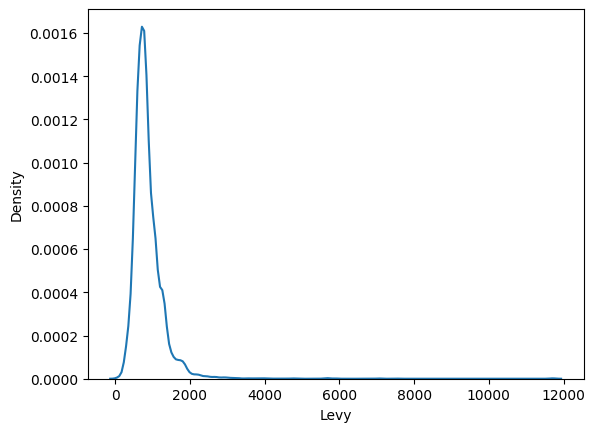

In [39]:
# Levy 특징 분포 확인
sns.kdeplot(df['Levy'])

<Axes: xlabel='Levy', ylabel='Density'>

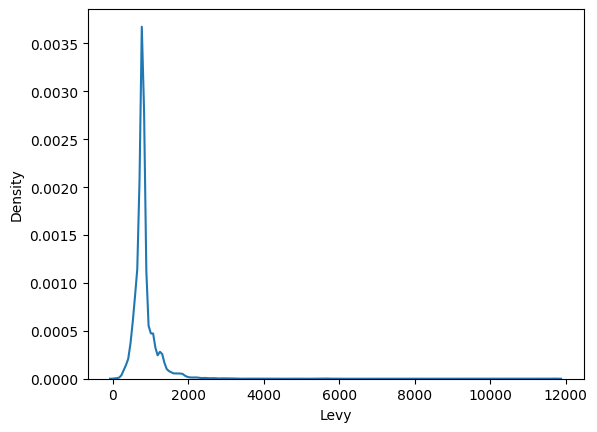

In [40]:
# Levy 특징 결측치를 중위수로 대체
df['Levy'].fillna(df['Levy'].median(), inplace=True)

sns.kdeplot(df['Levy'])

In [41]:
# 이상치들을 상계나 하계로 변환해줌
# 이상치 변환 함수 정의
def handling_outliers(data, columns):
    for col in columns:
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        for i in range(df.shape[0]):
            if data[col][i] < lower_bound:
                data[col][i] = lower_bound
            elif data[col][i] > upper_bound:
                data[col][i] = upper_bound
            else:
                continue
    return data


# 연속값들을 가지는 열 저장하기 위한 함수 정의
def get_continus_columns(data):
    obj = list(data.select_dtypes('object').columns)
    lst = list(data.columns)
    for col in obj:
        lst.remove(col)
    return lst
  
df_with_outliers = df.copy()

df = handling_outliers(df, get_continus_columns(df))

<ipython-input-41-9cdc4afa6602>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][i] = lower_bound
<ipython-input-41-9cdc4afa6602>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][i] = upper_bound
<ipython-input-41-9cdc4afa6602>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][i] = lower_bound
<ipython-input-41-9cdc4afa6602>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [42]:
# Labelencoder를 활용하여 모든 열의 값들을 수치 데이터로 변경
for col in df.select_dtypes('object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [43]:
# 학습을 위해 특징과 레이블을 정의
# MinMaxScaler를 통해 특징들을 정규화
x = df.drop(['Price'], axis=1).values
y = df['Price'].values
x = MinMaxScaler().fit_transform(x)

In [44]:
# 학습 데이터셋, 테스트 데이터셋을 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=5)

In [45]:
# 학습을 진행하는 ML 모델들을 정의
lr  = LinearRegression()
knn = KNeighborsRegressor(n_neighbors=8)
dt  = DecisionTreeRegressor(max_depth = 5)
rf  = RandomForestRegressor(n_estimators=100, max_features= 7)
ada = AdaBoostRegressor( n_estimators=150, learning_rate =.08)
gbr = GradientBoostingRegressor(max_depth=7, n_estimators=500, learning_rate =.05)
xgb = XGBRegressor(max_depth = 7, n_estimators=500, learning_rate =.05)
cb  = CatBoostRegressor(learning_rate =.07, max_depth =7, verbose=0)

regressors = [('Linear Regression', lr), ('K Nearest Neighbours', knn),('Decision Tree', dt), ('Random Forest', rf), 
              ('AdaBoost', ada),('Gradient Boosting Regressor', gbr),('XGBRegressor', xgb),('CatBoostRegressor', cb)]

Linear Regression : 38 %
K Nearest Neighbours : 63 %
Decision Tree : 49 %
Random Forest : 77 %
AdaBoost : 45 %
Gradient Boosting Regressor : 78 %
XGBRegressor : 78 %
CatBoostRegressor : 79 %


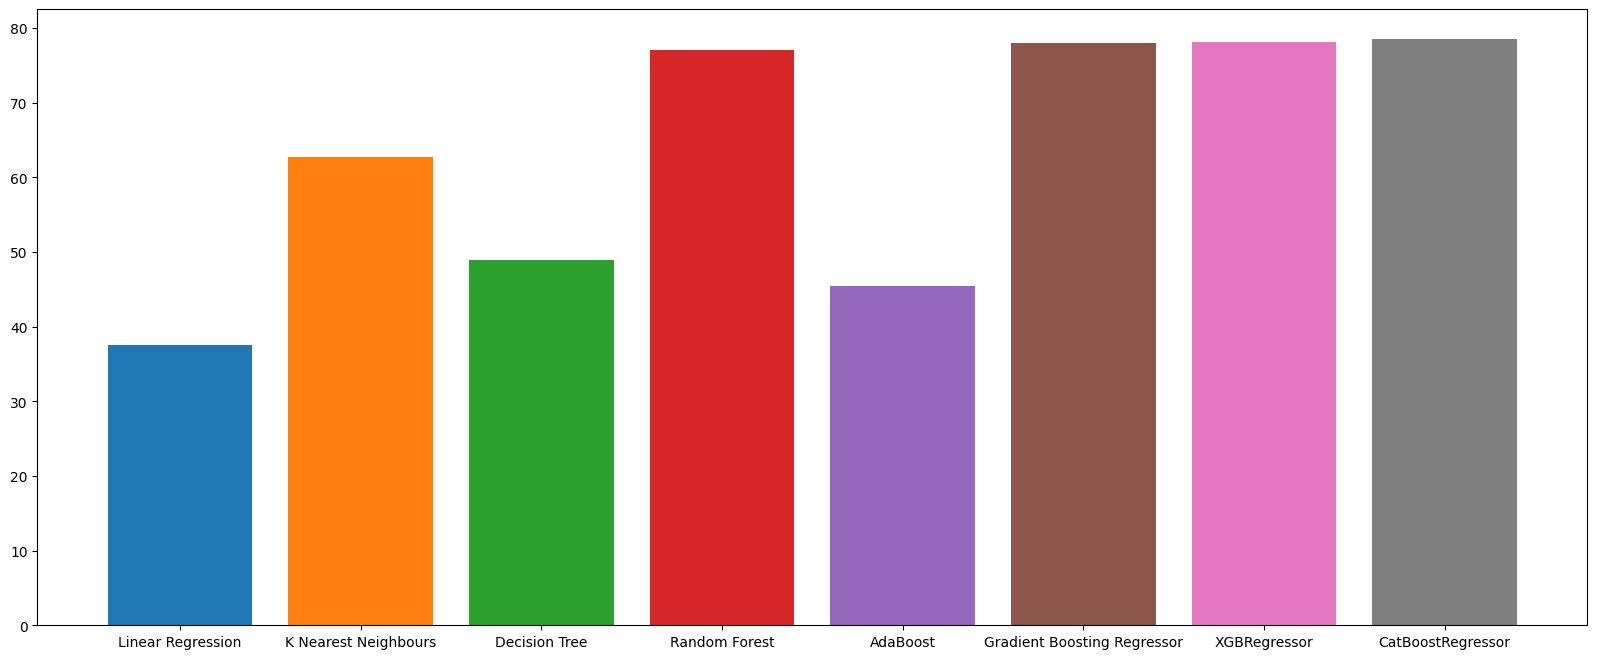

In [46]:
# 학습을 진행하고 결과를 확인
for regressor_name, regressor in regressors:

    regressor.fit(x_train, y_train)    
  
    y_pred = regressor.predict(x_test)
    accuracy = round(r2_score(y_test,y_pred),3)*100
    
    print('{:s} : {:.0f} %'.format(regressor_name, accuracy))
    plt.rcParams["figure.figsize"] = (20,8)
    plt.bar(regressor_name,accuracy)

Linear Regression : 57 %
K Nearest Neighbours : 63 %
Decision Tree : 53 %
Random Forest : 76 %
AdaBoost : 51 %
Gradient Boosting Regressor : 78 %
XGBRegressor : 78 %
CatBoostRegressor : 79 %


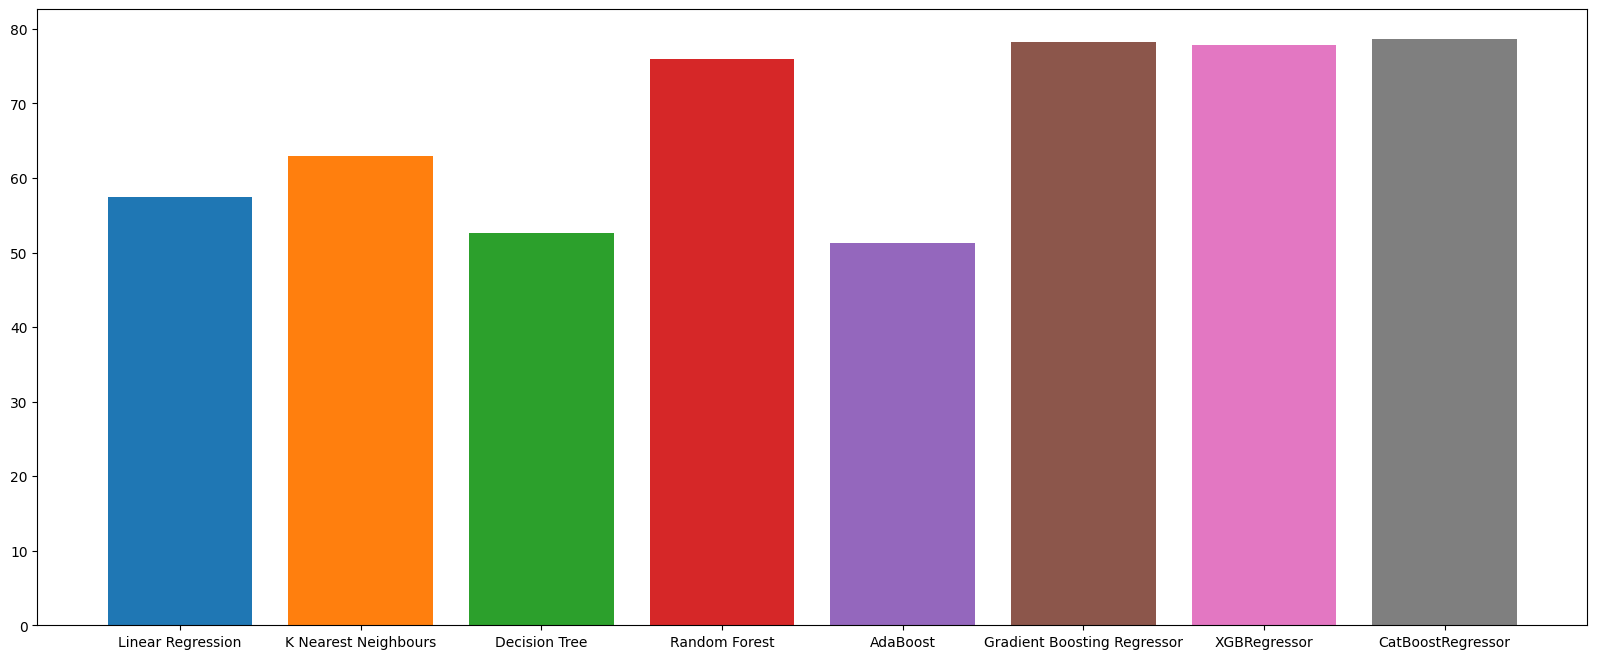

In [47]:
# 모델들의 학습을 진행하고 결과 확인
poly = PolynomialFeatures(degree=2)
x_train_trans = poly.fit_transform(x_train)
x_test_trans = poly.fit_transform(x_test)

for regressor_name, regressor in regressors:

    regressor.fit(x_train_trans, y_train)    
  
    y_pred = regressor.predict(x_test_trans)
    accuracy = round(r2_score(y_test,y_pred),3)*100
    
    print('{:s} : {:.0f} %'.format(regressor_name, accuracy))
    plt.rcParams["figure.figsize"] = (20,8)
    plt.bar(regressor_name,accuracy)